In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import  train_test_split
from sklearn.model_selection import GridSearchCV

import pickle

import gzip


os.chdir('../')
from functions.model_wrapper import Tree_Model, rfm_params, get_y_w_threshold


# These are batteries that show anomalies in the measnurements, and are therefore excluded.
excl_filenames = ['2018-04-12_batch8_CH46', '2017-06-30_3_6C-30per_6C_CH15', '2017-06-30_2C-7per_5_5C_CH12',
                  '2018-04-12_batch8_CH46', '2017-06-30_6C-60per_3C_CH48']

In [2]:
with gzip.open('data/filtered_data_frames.pckl', 'rb') as f:
    data_frames = pickle.load(f)

# Recreate the data grid

In [3]:
first100rows_data_frames = [data_frame.iloc[: 100, :] for data_frame in data_frames]
X_all = pd.concat(first100rows_data_frames, axis = 0)
X_all = X_all[[col for col in X_all.columns if col not in excl_filenames]]
X_all = X_all.T

# Convert schedule_version to categoric variable.

In [4]:
X_all["schedule_version"] = X_all["schedule_version"] == '7.00.08'

In [5]:
X_all.fillna(0, inplace = True)

In [6]:
X_CC = data_frames[0]
X_CC = X_CC[[col for col in X_CC.columns if col not in excl_filenames]]

# get y which is number of cycle it dropped below threshold
threshold = 0.9
y_all = get_y_w_threshold(X_CC, threshold)

# Create Grid Search parameters

In [7]:
parameters = {'max_depth' : [250, 500, 1000],
              'max_features' : [0.7, 0.6, 0.5, 'sqrt', 'log2'],
             }
# I reduced the number of estimators and n_jobs for grid search
rfm_params = {'n_estimators': 80,
              'bootstrap': True,
              'criterion': 'squared_error',
              'verbose': 1,
              'oob_score': True,
              'n_jobs': 8}

rfm_params["n_estimators"] = 40
rfm_params["n_jobs"] = 2
rfm_params["verbose"] = 0

# Grid search w RMS error as metric

/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-e_IOXrlx-py3.12/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


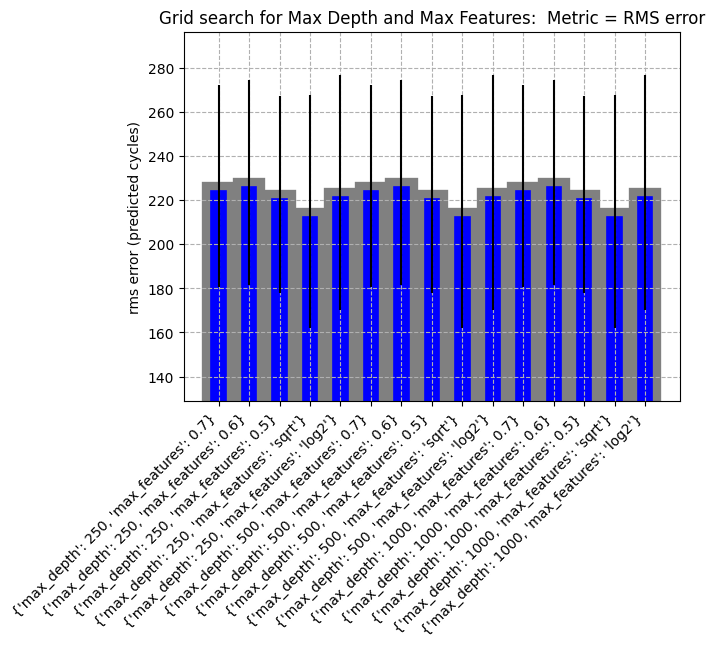

In [8]:
rfm = RandomForestRegressor(random_state = 1)
rfm.set_params(**rfm_params)
clf_rmse = GridSearchCV(rfm, parameters, scoring = 'neg_root_mean_squared_error', cv = 6)
clf_rmse.fit(X_all, y_all.values)

plt.title("Grid search for Max Depth and Max Features:  Metric = RMS error")
xlabels = [x for x in map(str, clf_rmse.cv_results_["params"])]
plt.bar(xlabels, 
        height = -clf_rmse.cv_results_["mean_test_score"],
        yerr=clf_rmse.cv_results_["std_test_score"],
        color = ['blue'],
        edgecolor = ['grey'],
        linewidth = 6
       )
plt.ylabel("rms error (predicted cycles)")
plt.xticks(rotation = 45, horizontalalignment="right")
plt.ylim(-clf_rmse.cv_results_["mean_test_score"].max()*0.6, -clf_rmse.cv_results_["mean_test_score"].min()*1.3)
plt.grid(linestyle = "--")
plt.show()

# Grid search w R^2 as metric

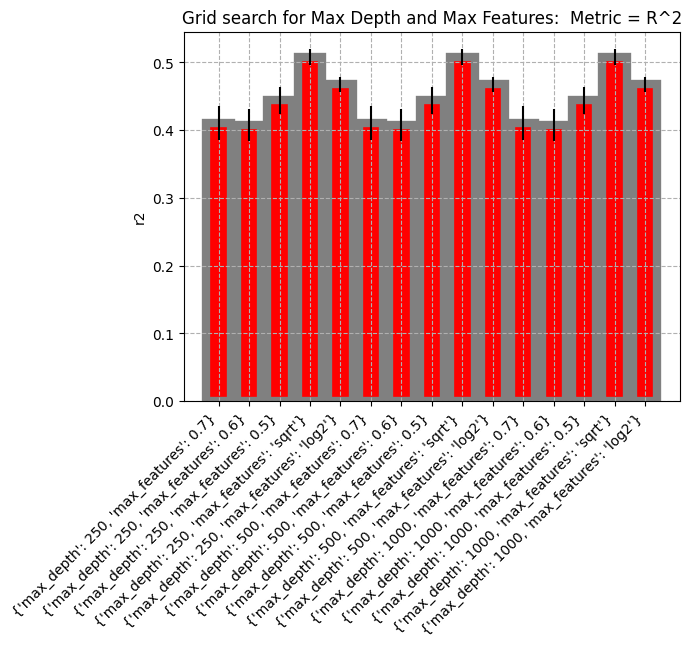

In [9]:
# Use R^2 as a metric for grid search
rfm = RandomForestRegressor(random_state = 1)
rfm.set_params(**rfm_params)
clf_r2 = GridSearchCV(rfm, parameters, scoring = 'r2', cv = 6)
clf_r2.fit(X_all, y_all.values)
plt.title("Grid search for Max Depth and Max Features:  Metric = R^2")
plt.bar(xlabels, 
        clf_r2.cv_results_["mean_test_score"], 
        yerr=clf_r2.cv_results_["std_test_score"]/10,
        color = ['r'],
        edgecolor = ['grey'],
        linewidth = 6
       )
plt.ylabel(clf_r2.scoring)
plt.xticks(rotation = 45, horizontalalignment="right")
# plt.ylim(clf_r2.cv_results_["mean_test_score"].min()*0.95, clf_r2.cv_results_["mean_test_score"].max()*1.05)
plt.grid(linestyle = "--")
plt.show()

# Best parameters: are max_depth = 250, max_features = 'sqrt'

In [10]:
rfm_params["n_estimators"] = 100000
rfm_params["n_jobs"] = 6
rfm_params["max_depth"] = 250
rfm_params["max_features"] = 'sqrt'
rfm_params["verbose"] = 1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    train_size=0.8, test_size=0.2, 
                                                    random_state=120)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  

Finished fitting.  Predicting X...


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  

Finished predicting X.
Training MdAPE is 4.895993453355161% (not holdout).
Finished training mdoel
MdAPE is 4.895993453355161%
R2: 0.939, RMSE: 79.310, MAE: 49.386
Plotting scatter plot...


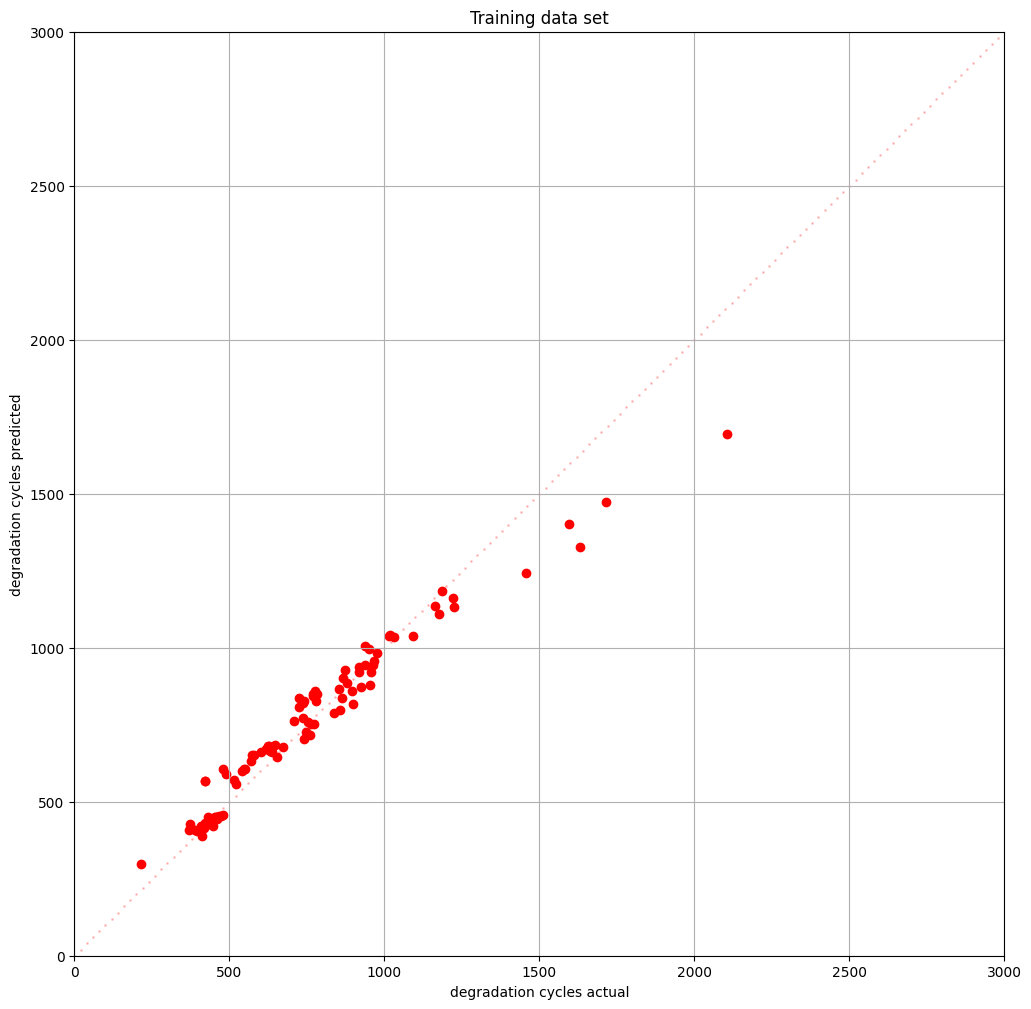

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  

MdAPE is 8.861681623931622%
R2: 0.598, RMSE: 205.523, MAE: 131.084
Plotting scatter plot...


[Parallel(n_jobs=6)]: Done 96788 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done 100000 out of 100000 | elapsed:    3.1s finished


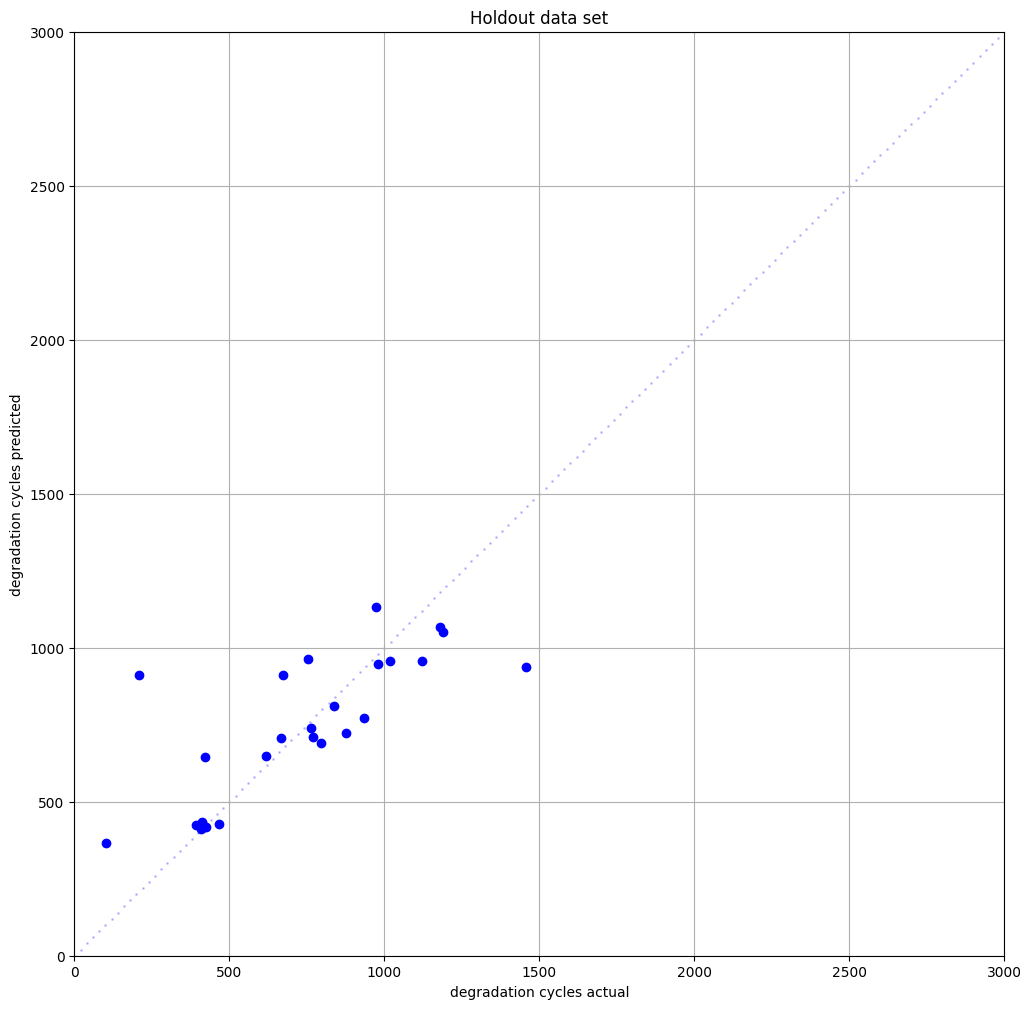

In [12]:
rfm = Tree_Model(Model = RandomForestRegressor,
                 params = rfm_params,
                 cycle_max=3000
                 )

rfm.fit(X_train, y_train)
y_test_pred = rfm.predict(X_test, y_test)

# From above, the HOLDOUT MdAPE = 8.86, R^2 = 0.598

In [13]:
with gzip.open('data/gzipX_all.pckl', 'wb') as f:
    pickle.dump(X_all, f)

with gzip.open('data/gzipy_all.pckl', 'wb') as f:
    pickle.dump(y_all, f)

with open('data/rfm_model_1e6.pckl', 'wb') as f:
    pickle.dump(rfm, f)

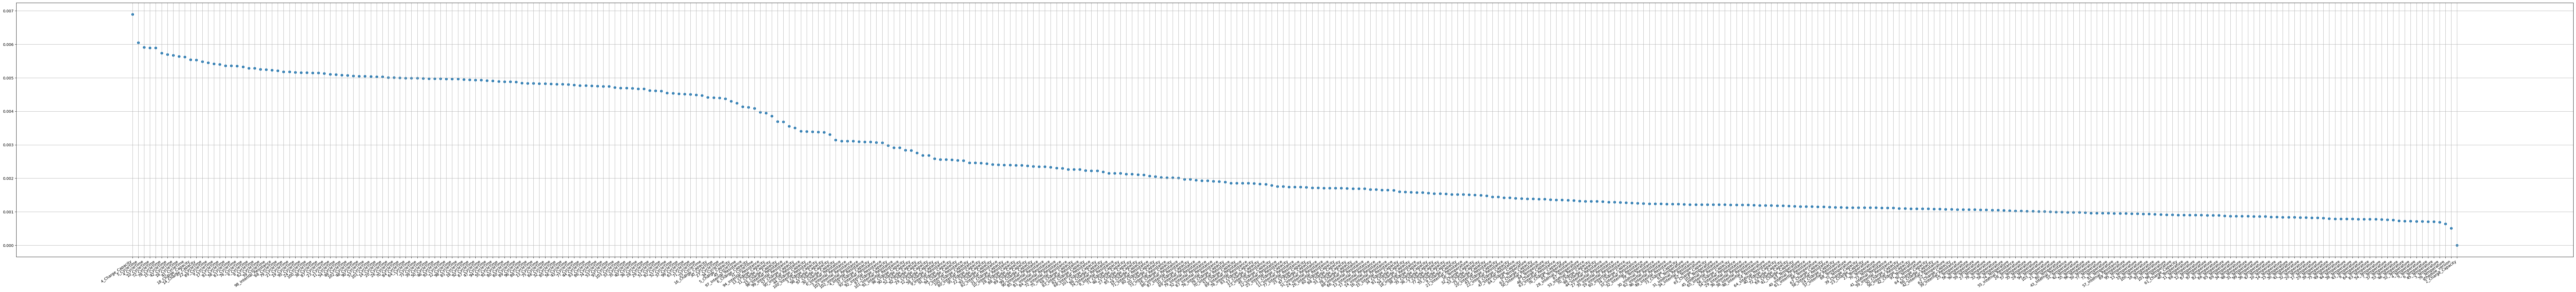

In [14]:
data_points =[x[0] for x in rfm.feature_imp]
importances =[x[1] for x in rfm.feature_imp]
plt.figure(figsize=(120,12))
plt.scatter(data_points, importances)
plt.xticks(rotation = 35, horizontalalignment = 'right')
plt.grid()
plt.savefig('figures/feature_imp.png')
plt.show()

In [15]:
importances_sums = {}
for feature_imp in rfm.feature_imp:
    category = feature_imp[0].split('_')[-1]
    if category in importances_sums.keys():
        importances_sums[category] += feature_imp[1]
    else:
        importances_sums[category] = feature_imp[1] 

import_sums = [(key, importances_sums[key]) for key in importances_sums.keys()]

import_sums = sorted(import_sums, key=lambda x: x[1], reverse = True)
str([(x[0], float(np.round(x[1], 5))) for x in import_sums])

"[('CycleTime', 0.49923), ('Capacity', 0.21458), ('Resistance', 0.19052), ('Temperature', 0.09515), ('version', 0.00051)]"

# Feature importances

In [16]:
feature_imp = sorted(rfm.feature_imp, key = lambda x: x[1], reverse = True)
with open('data/feature_importances_rfm1e6.pckl', 'wb') as f:
    pickle.dump(feature_imp,  f)      
feature_imp

[('4_Charge_Capacity', np.float64(0.006897151334438946)),
 ('5_CycleTime', np.float64(0.00605385403700854)),
 ('4_CycleTime', np.float64(0.005911571177067256)),
 ('10_CycleTime', np.float64(0.005894089526346597)),
 ('72_CycleTime', np.float64(0.00589261975636394)),
 ('78_CycleTime', np.float64(0.005740873891685893)),
 ('15_CycleTime', np.float64(0.005699960982873715)),
 ('42_CycleTime', np.float64(0.005669694932650591)),
 ('16_CycleTime', np.float64(0.005644054171673652)),
 ('41_CycleTime', np.float64(0.005623974421624796)),
 ('18_Charge_Capacity', np.float64(0.005545508756264734)),
 ('14_Charge_Capacity', np.float64(0.005536555734242807)),
 ('22_CycleTime', np.float64(0.0054843924528796915)),
 ('69_CycleTime', np.float64(0.005450065507707737)),
 ('9_CycleTime', np.float64(0.0054162345363732295)),
 ('17_CycleTime', np.float64(0.005403882965210815)),
 ('81_CycleTime', np.float64(0.005362622577376252)),
 ('58_CycleTime', np.float64(0.0053605848375386225)),
 ('61_CycleTime', np.float64(0.